# Building Vision Input from Existing Components

We have most of the code for processing vision from other projects. We just need to bring it together to make a video sensor.

One thing we need to do is quickly process video input to convert to a 1D numpy array. 

Options:
* Split visual field.
* Lightness / colour (start with L).
* Retinotopic mappings.
* Area of interest.

We'll look at square 2D blocks of sqrt(vec_len). Hence, vec_len is recommended to be a power of 4 - 4, 16 or 64. 4 and 16 are preferable to start.

We have a ```VideoSource``` object. We might need to add a BGR to YUV step -  img_out = cv2.cvtColor(img_in, cv2.COLOR_BGR2YUV). In code I set the property 16 to 0 ```self.cam.set(16, 0)```. Ah - 16 indicates whether the image should be converted to RGB. 0 turns this off to get original YUV.

In [24]:
from numpy.lib.stride_tricks import as_strided

def tile_array(a, b0, b1):
    """Tile array a in blocks of size b0 * b1"""
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view as 4D array
    return x.reshape(r*b0, c*b1)

def separate_components(frame, square=True):
    """Separate frame into YUV components.

    square - boolean - if true subsample the colour images so they are square
    """
    if square:
        return frame[:, :, 0], frame[::2, 1::2, 1], frame[::2, 0::2, 1]
    else:
        return frame[:, :, 0], frame[:, 1::2, 1], frame[:, 0::2, 1]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [3]:
import cv2
from matplotlib.animation import FuncAnimation

In [4]:
from src.sources.video import VideoSource

In [5]:
video = VideoSource()

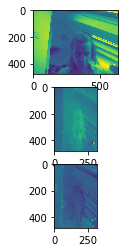

In [9]:
_, frame = video.read()
components = separate_components(frame, square=False)
fig, axes = plt.subplots(3, 1)
for ax, comp in zip(axes.ravel(), components):
    ax.imshow(comp)
plt.show()

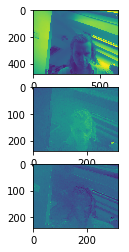

In [10]:
_, frame = video.read()
components = separate_components(frame, square=True)
fig, axes = plt.subplots(3, 1)
for ax, comp in zip(axes.ravel(), components):
    ax.imshow(comp)
plt.show()

In [11]:
frame.shape

(480, 640, 2)

<IPython.core.display.Javascript object>


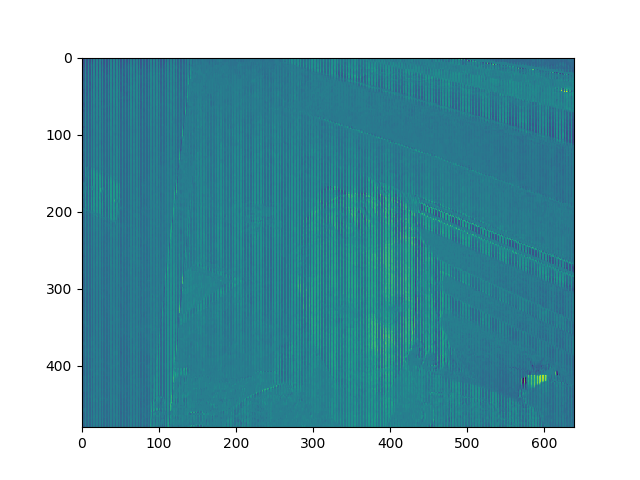

In [12]:
%matplotlib notebook
plt.imshow(frame[..., 1])

In [13]:
video.cap.release()

In [ ]:
from src.sources.video import YSource

In [ ]:
yvideo = YSource()

In [ ]:
_, frame = yvideo.read()
print(frame.shape)
plt.imshow(frame)

Why is the frame not updating?

In [ ]:
plt.imshow(yvideo.cap.read()[1][..., 0])

It is updating - just very slowly.

In [ ]:
yvideo.cap.release()

In [ ]:
yvideo = YSource(width=256, height=256)

In [ ]:
_, frame = yvideo.read(); print(frame.shape)

plt.imshow(frame)

In [ ]:
plt.imshow(yvideo.cap.read()[1][..., 0])

In [ ]:
yvideo.cap.release()

Is it just the VideoSource object? Let's try creating a video feed via matplotlib...

In [ ]:
cam = cv2.VideoCapture(0)
cam.set(16, 0)

In [ ]:
ret, frame = cam.read()

In [ ]:
print(ret, frame)

In [ ]:
cam.release()

In [14]:
class VideoViewer:
    """Object to view video via matplotlib."""
    def __init__(self):
        """Initialise"""
        self.cam = cv2.VideoCapture(0)
        self.cam.set(16, 0)
        self.figure, self.ax1 = plt.subplots(1, 1)
        self.animation = FuncAnimation(self.figure, self.update, interval=200, blit=True)
        frame = self.process_frame()
        self.img = self.ax1.imshow(frame, cmap="gray", animated=True)
    
    def process_frame(self):
        """Process a frame. 
    
        cam is a cv2 capture object."""
        ret, frame = self.cam.read()
        if ret: 
            # Just return Y
            frame = frame[..., 0]
        else:
            frame = np.zeros(shape=(480, 640))
        return frame
    
    def update(self, i):
        """Code for frame update."""
        frame = self.process_frame()
        self.img.set_data(frame)
        return self.figure
    
    def show(self):
        plt.show()
        
    def __exit__(self, exec_type, exc_value, traceback):
        """Extra code to close camera."""
        self.cam.release()

<IPython.core.display.Javascript object>


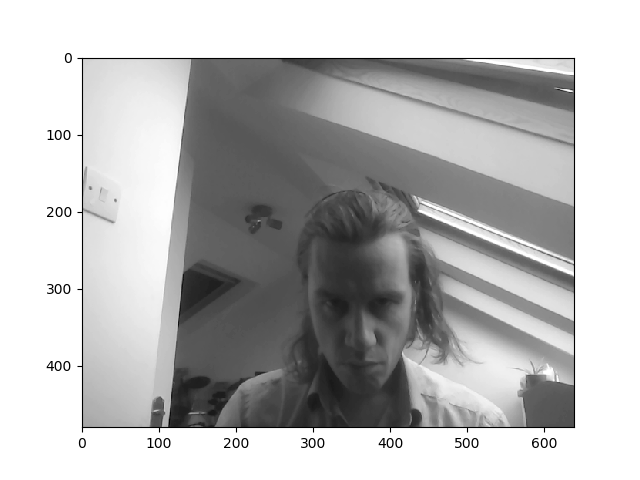

In [20]:
video = VideoViewer()

In [18]:
video.show()

In [19]:
video.cam.release()

So that video viewer code does work.

In [21]:
frame = video.process_frame()

In [22]:
frame.shape

(480, 640)

In [25]:
tiled = tile_array(frame, 2, 2)

In [26]:
tiled.shape

(960, 1280)

plt.imshow(tiled)

No - tile_array is not the function I need.

Before we used a for loop.
```
for row_idx in range(0, num_row_iterations):
            for column_idx in range(0, num_column_iterations):
                self.pe_units[i].r_PE = im_array[
                    n*row_idx:n*(row_idx+1), n*column_idx:n*(column_idx+1)
                ].flatten()
```
                
But see the image feature extraction section here- https://realpython.com/numpy-array-programming/. Ah tile_array is close...

Strides parameter is here - https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.strides.html.

Scikit learn has a function that does this that we can copy for Cython implementations - https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/feature_extraction/image.py#L343. See the \_extract_patches function.

In [28]:
a = frame
r, c = a.shape  # number of rows/columns
print(r, c)
rs, cs = a.strides  # row/column strides
print(rs, cs)

480 640
1280 2


So the strides means that we need to move 2 bytes to get to the next column value and 640\*2 bytes to get to the next row (imagining we move along the columns in a row before we move to the next row).

So for the [1, 1] entry we have 1280\*1 (skip one row) + 2\*1 (skip one column) = byte 1282

In [29]:
a.dtype

dtype('uint8')

In [30]:
a.nbytes

307200

In [31]:
480*640*1

307200

In [32]:
a.itemsize

1

In [33]:
vec_len = 2
shape = (frame.shape[0] - vec_len + 1, frame.shape[1] - vec_len + 1, vec_len, vec_len); print(shape)

(479, 639, 2, 2)


In [34]:
strides = 2 * frame.strides; print(strides)

(1280, 2, 1280, 2)


Why are the strides twice the frame strides?

In [35]:
patches = as_strided(frame, shape=shape, strides=strides)

In [36]:
patches.shape

(479, 639, 2, 2)

In [37]:
flat_block_len = vec_len ** 2
flattened = patches.reshape(*patches.shape[:2], flat_block_len)

In [38]:
flattened.shape

(479, 639, 4)

In [39]:
arr = frame
arr_ndim = arr.ndim; print(arr_ndim)

2


In [55]:
extraction_step = vec_len

In [56]:
extraction_step = tuple([extraction_step] * arr_ndim)
print(extraction_step)

(2, 2)


In [57]:
patch_strides = arr.strides

slices = tuple(slice(None, None, st) for st in extraction_step)
print(slices)

(slice(None, None, 2), slice(None, None, 2))


In [58]:
indexing_strides = arr[slices].strides

In [79]:
print(indexing_strides, arr.strides)

(2560, 4) (1280, 2)


In [60]:
patch_shape = tuple([vec_len] * arr_ndim); print(patch_shape)
patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1
print(patch_indices_shape)

shape = tuple(list(patch_indices_shape) + list(patch_shape))
strides = tuple(list(indexing_strides) + list(patch_strides))
print(shape, strides)

(2, 2)
[240 320]
(240, 320, 2, 2) (2560, 4, 1280, 2)


In [61]:
patches = as_strided(arr, shape=shape, strides=strides)

In [62]:
patches.shape

(240, 320, 2, 2)

In [63]:
flattened = patches.reshape(*patches.shape[:2], vec_len**2); print(flattened.shape)

(240, 320, 4)


The first two dimensions reflect the index of the top corner of the block.

In [80]:
patches[0, 0, :, :], flattened[0, 0, :]

(array([[195, 196],
        [195, 195]], dtype=uint8), array([195, 196, 195, 195], dtype=uint8))

In [65]:
one_d = patches.flatten()

In [82]:
patches[0:2, 0:2, :, :], flattened[0:2, 0:2, :], one_d[0:30]

(array([[[[195, 196],
          [195, 195]],
 
         [[195, 195],
          [196, 196]]],
 
 
        [[[195, 195],
          [196, 196]],
 
         [[196, 197],
          [197, 197]]]], dtype=uint8), array([[[195, 196, 195, 195],
         [195, 195, 196, 196]],
 
        [[195, 195, 196, 196],
         [196, 197, 197, 197]]], dtype=uint8), array([195, 196, 195, 195, 195, 195, 196, 196, 196, 197, 196, 198, 198,
        197, 198, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198,
        198, 198, 199, 198], dtype=uint8))

Ah it is the one_d here that isn't flattened in order. I remember - I need to swap the axes so the 2, 2 come first. In other code I used ```.swapaxes(1, 2).reshape(H*width, W*width)```.

Look up transformation.py in the predictive_coding repository.

In [107]:
A = frame
width = 2
H, W = A.shape
# Reshape to divide by width, then swap axes and reform
img_views_array = A.reshape(
    H//width, width, W//width, width
).swapaxes(2, 1).reshape(
    H//width, W//width, width**2
)

In [108]:
img_views_array.shape

(240, 320, 4)

In [111]:
frame[0:10, 0:10]

array([[195, 196, 195, 195, 196, 197, 198, 197, 197, 198],
       [195, 195, 196, 196, 196, 198, 198, 197, 198, 198],
       [195, 195, 196, 197, 198, 198, 198, 198, 198, 198],
       [196, 196, 197, 197, 198, 198, 198, 198, 198, 198],
       [196, 196, 197, 197, 198, 198, 198, 198, 198, 198],
       [197, 197, 197, 198, 198, 198, 198, 198, 199, 199],
       [198, 198, 198, 198, 198, 198, 198, 198, 198, 199],
       [198, 198, 198, 198, 199, 199, 199, 199, 199, 199],
       [198, 198, 198, 199, 199, 199, 199, 199, 199, 199],
       [198, 198, 199, 199, 199, 199, 199, 199, 200, 199]], dtype=uint8)

In [120]:
test = np.arange(64).reshape(8,8); print(test)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [122]:
reshaped = test.reshape(4, 2, 4, 2); print(reshaped)

[[[[ 0  1]
   [ 2  3]
   [ 4  5]
   [ 6  7]]

  [[ 8  9]
   [10 11]
   [12 13]
   [14 15]]]


 [[[16 17]
   [18 19]
   [20 21]
   [22 23]]

  [[24 25]
   [26 27]
   [28 29]
   [30 31]]]


 [[[32 33]
   [34 35]
   [36 37]
   [38 39]]

  [[40 41]
   [42 43]
   [44 45]
   [46 47]]]


 [[[48 49]
   [50 51]
   [52 53]
   [54 55]]

  [[56 57]
   [58 59]
   [60 61]
   [62 63]]]]


In [123]:
swapped = reshaped.swapaxes(2,1).; print(swapped)

[[[[ 0  1]
   [ 8  9]]

  [[ 2  3]
   [10 11]]

  [[ 4  5]
   [12 13]]

  [[ 6  7]
   [14 15]]]


 [[[16 17]
   [24 25]]

  [[18 19]
   [26 27]]

  [[20 21]
   [28 29]]

  [[22 23]
   [30 31]]]


 [[[32 33]
   [40 41]]

  [[34 35]
   [42 43]]

  [[36 37]
   [44 45]]

  [[38 39]
   [46 47]]]


 [[[48 49]
   [56 57]]

  [[50 51]
   [58 59]]

  [[52 53]
   [60 61]]

  [[54 55]
   [62 63]]]]


In [124]:
test.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [129]:
reshaped2 = test.reshape(2, 4, 2, 4)
swapped2 = reshaped2.swapaxes(2, 1).reshape(4, 4, 4); print(swapped2)

[[[ 0  1  2  3]
  [ 8  9 10 11]
  [16 17 18 19]
  [24 25 26 27]]

 [[ 4  5  6  7]
  [12 13 14 15]
  [20 21 22 23]
  [28 29 30 31]]

 [[32 33 34 35]
  [40 41 42 43]
  [48 49 50 51]
  [56 57 58 59]]

 [[36 37 38 39]
  [44 45 46 47]
  [52 53 54 55]
  [60 61 62 63]]]


In [131]:
print(swapped2[:, 0, 0], swapped[0, 0, :])

[ 0  4 32 36] [[0 1]
 [8 9]]


In [133]:
swapped[1, 1, :]

array([[18, 19],
       [26, 27]])

In [139]:
flat = swapped.flatten()

In [140]:
swapped.shape, flat.shape

((4, 4, 2, 2), (64,))

In [143]:
flat.reshape(4, 4, 2, 2).swapaxes(2, 1).reshape(8, 8)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [144]:
def flatten_frame(frame, vec_len):
    """Flatten a frame of video to a 1D array using clustered blocks of size vec_len."""
    rows = frame.shape[0] // vec_len
    cols = frame.shape[1] // vec_len
    return frame.reshape(rows, vec_len, cols, vec_len).swapaxes(2, 1).flatten()

def reconstruct_frame(array, vec_len, rows, cols):
    """Reconstruct a 1D array of clustered blocks into a 2D image.
    
    rows, cols are original shape."""
    return array.reshape(rows//vec_len, cols//vec_len, vec_len, vec_len).swapaxes(2, 1).reshape(rows, cols)

In [146]:
f = flatten_frame(test, 4); f

array([ 0,  1,  2,  3,  8,  9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27,  4,
        5,  6,  7, 12, 13, 14, 15, 20, 21, 22, 23, 28, 29, 30, 31, 32, 33,
       34, 35, 40, 41, 42, 43, 48, 49, 50, 51, 56, 57, 58, 59, 36, 37, 38,
       39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 62, 63])

In [150]:
f2 = flatten_frame(test, 2); f2

array([ 0,  1,  8,  9,  2,  3, 10, 11,  4,  5, 12, 13,  6,  7, 14, 15, 16,
       17, 24, 25, 18, 19, 26, 27, 20, 21, 28, 29, 22, 23, 30, 31, 32, 33,
       40, 41, 34, 35, 42, 43, 36, 37, 44, 45, 38, 39, 46, 47, 48, 49, 56,
       57, 50, 51, 58, 59, 52, 53, 60, 61, 54, 55, 62, 63])

In [152]:
assert np.array_equal(f2[0:4], np.asarray([0,  1,  8,  9,]))

In [147]:
reconstruct_frame(f, 4, 8, 8)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [149]:
len(f.shape)

1

In [162]:
def test_flatten_reconstruct():
    # Build test array
    test = np.arange(64).reshape(8,8)
    # Test flattening in blocks of 4x4
    flat4 = flatten_frame(test, 4)
    assert flat4.shape[0] == 64
    assert len(flat4.shape) == 1
    assert np.array_equal(flat4[0:4], np.arange(4))
    assert np.array_equal(flat4[4:8], np.asarray([8,  9,  10,  11]))
    # Test flattening in blocks of 2x2
    flat2 = flatten_frame(test, 2)
    assert flat2.shape[0] == 64
    assert len(flat2.shape) == 1
    assert np.array_equal(flat2[0:4], np.asarray([0,  1,  8,  9]))
    assert np.array_equal(flat2[4:8], np.asarray([2,  3, 10, 11]))
    # Test reconstruction
    reconstructed4 = reconstruct_frame(flat4, 4, 8, 8)
    assert np.array_equal(reconstructed4, test)
    reconstructed2 = reconstruct_frame(flat2, 2, 8, 8)
    assert np.array_equal(reconstructed2, test)

In [163]:
f[4:8], np.arange(4, 8)

(array([ 8,  9, 10, 11]), array([4, 5, 6, 7]))

In [164]:
test_flatten_reconstruct()

In [93]:
H2, W2, S = img_views_array.shape
width = int(np.sqrt(S))
# Reshape to w by w, then swap W and w
A2 = img_views_array.reshape(
    H2, W2, width, width
).swapaxes(1, 2).reshape(H2*width, W2*width)

<IPython.core.display.Javascript object>


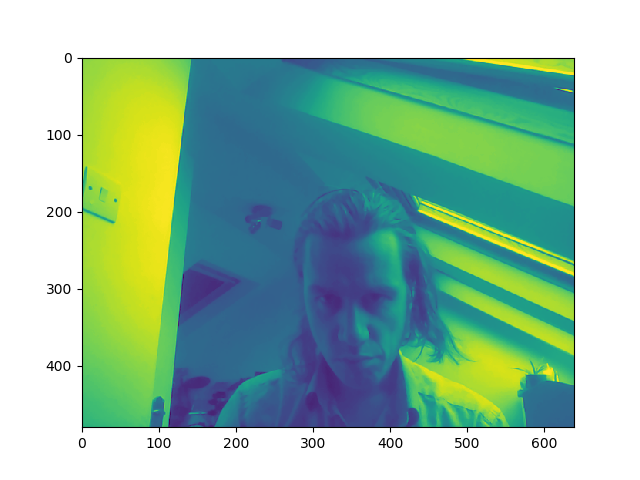

In [94]:
plt.imshow(A2)

In [95]:
A = frame
width = 2
H, W = A.shape
# Reshape to divide by width, then swap axes and reform
img_views_array = A.reshape(
    width, H//width, width, W//width
).swapaxes(2, 1).reshape(
    width**2, H//width, W//width 
)

In [97]:
img_views_array.shape

(4, 240, 320)

In [98]:
one_d_v2 = img_views_array.flatten()
print(one_d_v2.shape, one_d_v2[0:30])

(307200,) [195 196 195 195 196 197 198 197 197 198 198 198 198 198 199 198 198 199
 200 199 198 200 201 201 201 201 201 201 201 201]


In [106]:
frame[0:10, 0:10], img_views_array[:, 0:2, 0:2]

(array([[195, 196, 195, 195, 196, 197, 198, 197, 197, 198],
        [195, 195, 196, 196, 196, 198, 198, 197, 198, 198],
        [195, 195, 196, 197, 198, 198, 198, 198, 198, 198],
        [196, 196, 197, 197, 198, 198, 198, 198, 198, 198],
        [196, 196, 197, 197, 198, 198, 198, 198, 198, 198],
        [197, 197, 197, 198, 198, 198, 198, 198, 199, 199],
        [198, 198, 198, 198, 198, 198, 198, 198, 198, 199],
        [198, 198, 198, 198, 199, 199, 199, 199, 199, 199],
        [198, 198, 198, 199, 199, 199, 199, 199, 199, 199],
        [198, 198, 199, 199, 199, 199, 199, 199, 200, 199]], dtype=uint8),
 array([[[195, 196],
         [195, 195]],
 
        [[ 83,  84],
         [ 83,  84]],
 
        [[204, 204],
         [204, 204]],
 
        [[ 64,  64],
         [ 64,  64]]], dtype=uint8))

In [100]:
reshaped = one_d_v2.reshape(4, 240, 320)

In [103]:
S, H2, W2 = reshaped.shape
width = int(np.sqrt(S))
# Reshape to w by w, then swap W and w
A2 = reshaped.reshape(
    width, width, H2, W2 
).swapaxes(1, 2).reshape(H2*width, W2*width)

<IPython.core.display.Javascript object>


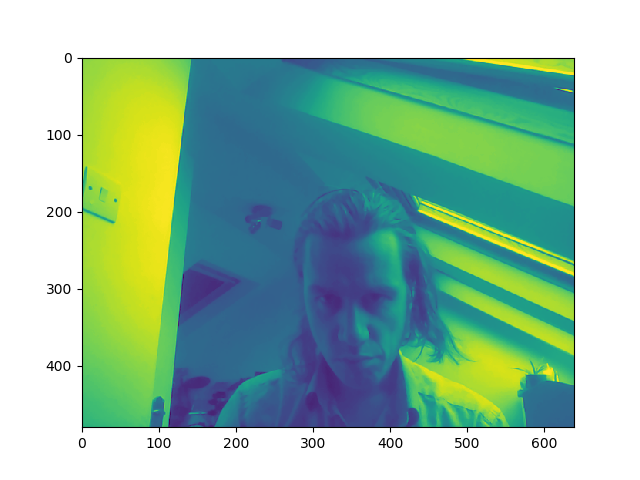

In [104]:
plt.imshow(A2)

In [85]:
one_d_2 = patches.reshape(patches.shape[0]*patches.shape[1], 2, 2)
print(one_d_2.shape, one_d_2[0:30])

(76800, 2, 2) [[[195 196]
  [195 195]]

 [[195 195]
  [196 196]]

 [[196 197]
  [196 198]]

 [[198 197]
  [198 197]]

 [[197 198]
  [198 198]]

 [[198 198]
  [198 198]]

 [[198 198]
  [198 198]]

 [[199 198]
  [199 199]]

 [[198 199]
  [199 200]]

 [[200 199]
  [200 199]]

 [[198 200]
  [198 199]]

 [[201 201]
  [201 201]]

 [[201 201]
  [201 201]]

 [[201 201]
  [201 201]]

 [[201 201]
  [201 201]]

 [[201 202]
  [201 201]]

 [[203 203]
  [202 203]]

 [[203 203]
  [203 203]]

 [[203 202]
  [203 202]]

 [[202 202]
  [203 202]]

 [[202 202]
  [202 202]]

 [[202 202]
  [202 202]]

 [[202 202]
  [202 202]]

 [[203 203]
  [203 203]]

 [[203 204]
  [203 204]]

 [[204 204]
  [204 204]]

 [[204 204]
  [204 204]]

 [[204 204]
  [204 204]]

 [[203 203]
  [203 203]]

 [[204 203]
  [204 203]]]


In [66]:
one_d[0:4]

array([195, 196, 195, 195], dtype=uint8)

In [ ]:
one_d[64:68], 

Then how do we reconstruct?! Scikit learn just iterates over the image. We can't use the same code because it has overlaps. Can we reverse engineer the views?

In [67]:
one_d.shape

(307200,)

In [ ]:
def image_to_vector(image, vec_len):
    """Convert an image to a vector based on 2D blocks of width
    and height equal to vec_len - e.g. 2x2.
    
    Returns:
        1D vector in block order.
    """
    # General extraction steps in 2D
    extraction_step = tuple([vec_len] * image.ndim)
    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides
    patch_shape = extraction_step
    patch_indices_shape = ((np.array(image.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1
    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))
    patches = as_strided(arr, shape=shape, strides=strides)
    flattened = patches.reshape(*patches.shape[:2], vec_len**2)
    return 

In [69]:
i_h, i_w = 640, 480
img = np.zeros(shape=(i_w, i_h))
# compute the dimensions of the patches array
n_h = i_h - vec_len + 1
n_w = i_w - vec_len + 1
print(n_h, n_w)

639 479


n_h and n_w are the same as the shape parameters above.

In [71]:
from itertools import product

In [74]:
list(product(range(3), range(3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [76]:
# Naive way
k = 0
for i in range(i_w//vec_len):
    for j in range(i_h//vec_len):
        img[i*vec_len:(i+1)*vec_len, j*vec_len:(j+1)*vec_len] = one_d[k:k+vec_len**2].reshape(2, 2)
        k += 1

<IPython.core.display.Javascript object>


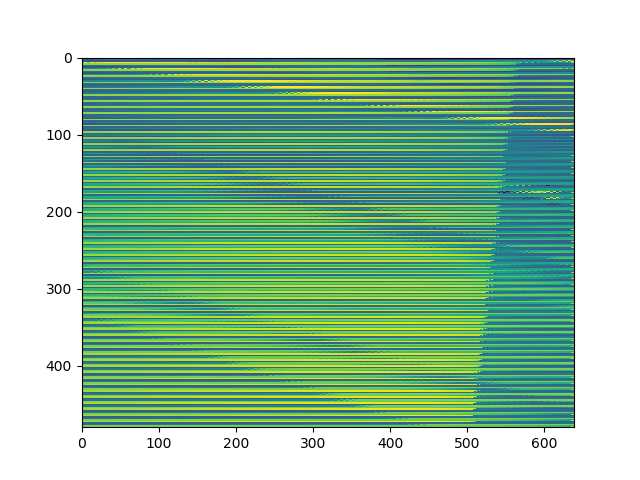

In [77]:
plt.imshow(img)

<IPython.core.display.Javascript object>


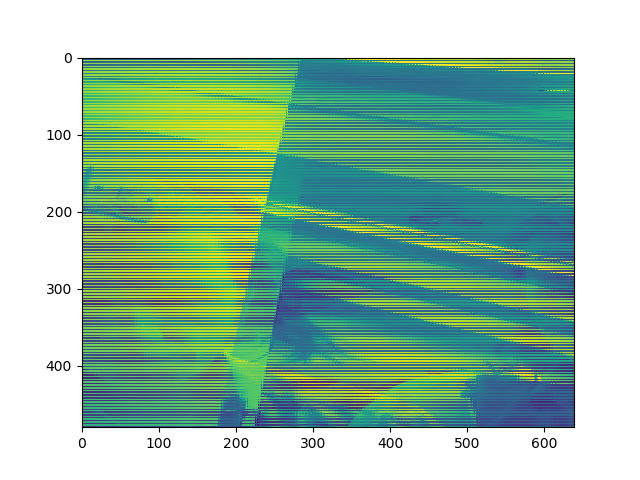

In [78]:
plt.imshow(one_d.reshape(480, 640))